In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib import pyplot

sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})

pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

In [2]:
SWaT_Dataset_Normal_v0 = pd.read_pickle('dataset/SWaT_Dataset_Normal_v0.pkl')
SWaT_Dataset_Normal_v1 = pd.read_pickle('dataset/SWaT_Dataset_Normal_v1.pkl')
SWaT_Dataset_Attack_v0 = pd.read_pickle('dataset/SWaT_Dataset_Attack_v0.pkl')

## Check difference between SWaT_Dataset_Normal_v0 and SWaT_Dataset_Normal_v1

In [3]:
print(len(SWaT_Dataset_Normal_v0))
print(len(SWaT_Dataset_Normal_v1))
print(len(SWaT_Dataset_Attack_v0))

496800
495000
449919


### Check difference between SWaT_Dataset_Normal_v0 and SWaT_Dataset_Normal_v1

In [4]:
d1 = SWaT_Dataset_Normal_v0.iloc[1800:]
d2 = SWaT_Dataset_Normal_v1.iloc[:]

In [5]:
d1 = d1.reset_index(drop=True)
d2 = d2.reset_index(drop=True)

In [6]:
d3 = pd.concat([d1['P1']['FIT101'], d2['P1']['FIT101']], axis=1)

In [7]:
d3['difference'] = d3.apply(lambda x: x[0] - x[1], axis=1)

In [8]:
d3['difference'].sum()

0.0

## Clean dataset

In [9]:
SWaT_Dataset_Attack_v0.columns = SWaT_Dataset_Normal_v0.columns

In [10]:
df = SWaT_Dataset_Normal_v0.append(SWaT_Dataset_Attack_v0)
df = df.reset_index(drop=True)

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_18507/2082133822.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = SWaT_Dataset_Normal_v0.append(SWaT_Dataset_Attack_v0)


Create clean dataset

In [11]:
df = pd.concat([df['Unnamed: 0_level_0'], df['P1'], df['P2'], df['P3'], df['P4'], df['P5'], df['P6']], axis=1)

In [12]:
time_1 = df.iloc[len(df)-1].values[0]
print(time_1)
time_1 = pd.to_datetime(time_1, format='%d/%m/%Y %H:%M:%S %p')
time_1

 2/1/2016 2:59:59 PM


Timestamp('2016-01-02 02:59:59')

In [13]:
time_2 = df.iloc[0].values[0]
print(time_2)
time_2 = pd.to_datetime(time_2, format=' %d/%m/%Y %I:%M:%S %p')
time_2

 22/12/2015 4:00:00 PM


Timestamp('2015-12-22 16:00:00')

Add index column

In [14]:
df['index'] = [i for i in range(len(df))]

Clean Timestamp column

In [15]:
list(df.columns)[0]

' Timestamp'

In [16]:
df.rename(columns={' Timestamp':'Timestamp'}, inplace=True)

set the format on timestamp 

In [17]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=' %d/%m/%Y %I:%M:%S %p')

Clean Normal/Attack column

In [18]:
df['Normal/Attack'].value_counts()

Normal     892098
Attack      54584
A ttack        37
Name: Normal/Attack, dtype: int64

In [19]:
typos = {
    "Attack": ["A ttack"],
}
c = "Normal/Attack"
for expected, founds in typos.items():
    for typo in founds:
        s = df[c] == typo
        df.loc[s, c] = expected

In [20]:
df['Normal/Attack'].value_counts()

Normal    892098
Attack     54621
Name: Normal/Attack, dtype: int64

In [21]:
for col in df.columns:
    if df[col].isna().sum() != 0:
        print(col, df[col].isna().sum())

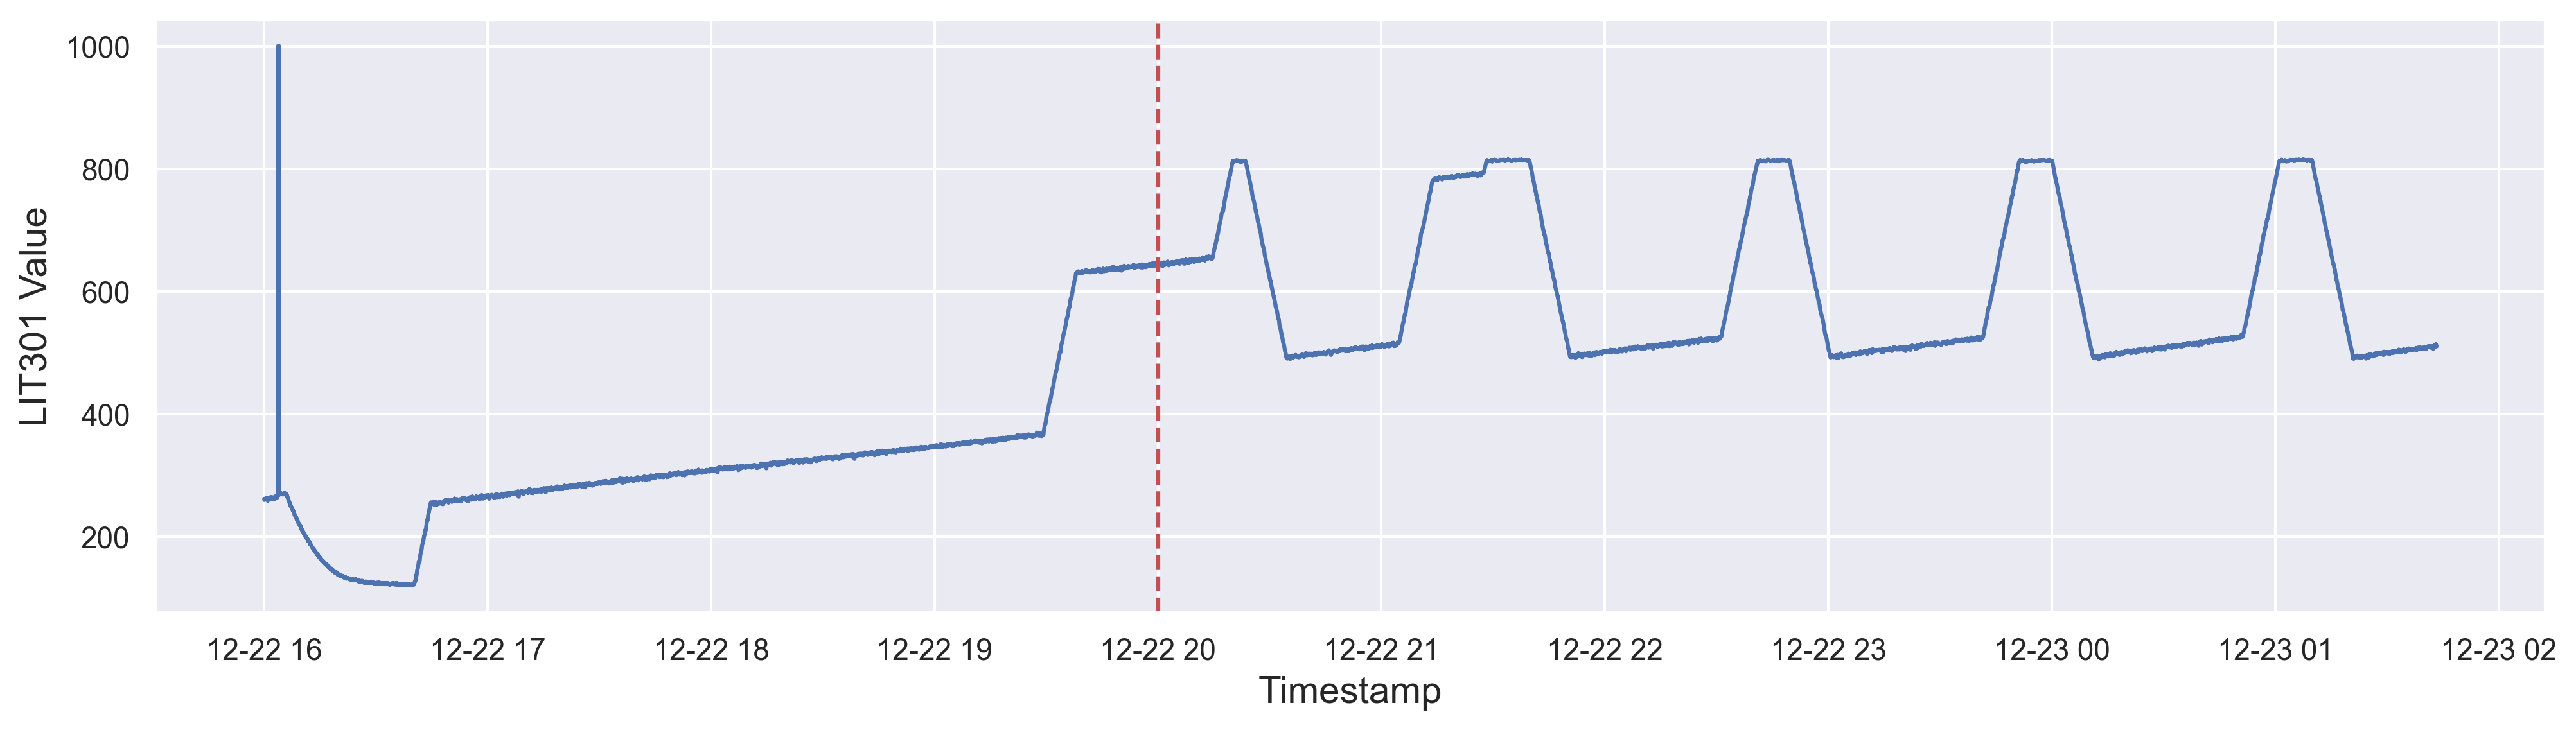

In [24]:
fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
# ax.plot(df['Timestamp'].iloc[0:50000], df['LIT301'].iloc[0:50000])
# ax1 = ax.twinx()
ax.plot(df['Timestamp'].iloc[0:35000], df['LIT101'].iloc[0:35000])
# add labels
ax.set_xlabel('Timestamp', fontsize=14)
ax.set_ylabel('LIT301 Value', fontsize=14)
# make a line at Timestamp == 2015-12-22 19:59:59
index = pd.to_datetime('2015-12-22 19:59:59', format='%Y-%m-%d %H:%M:%S')

ax.axvline(x=index, color='r', linestyle='--')

fig.savefig('figures/remove_starting.pdf', bbox_inches='tight')

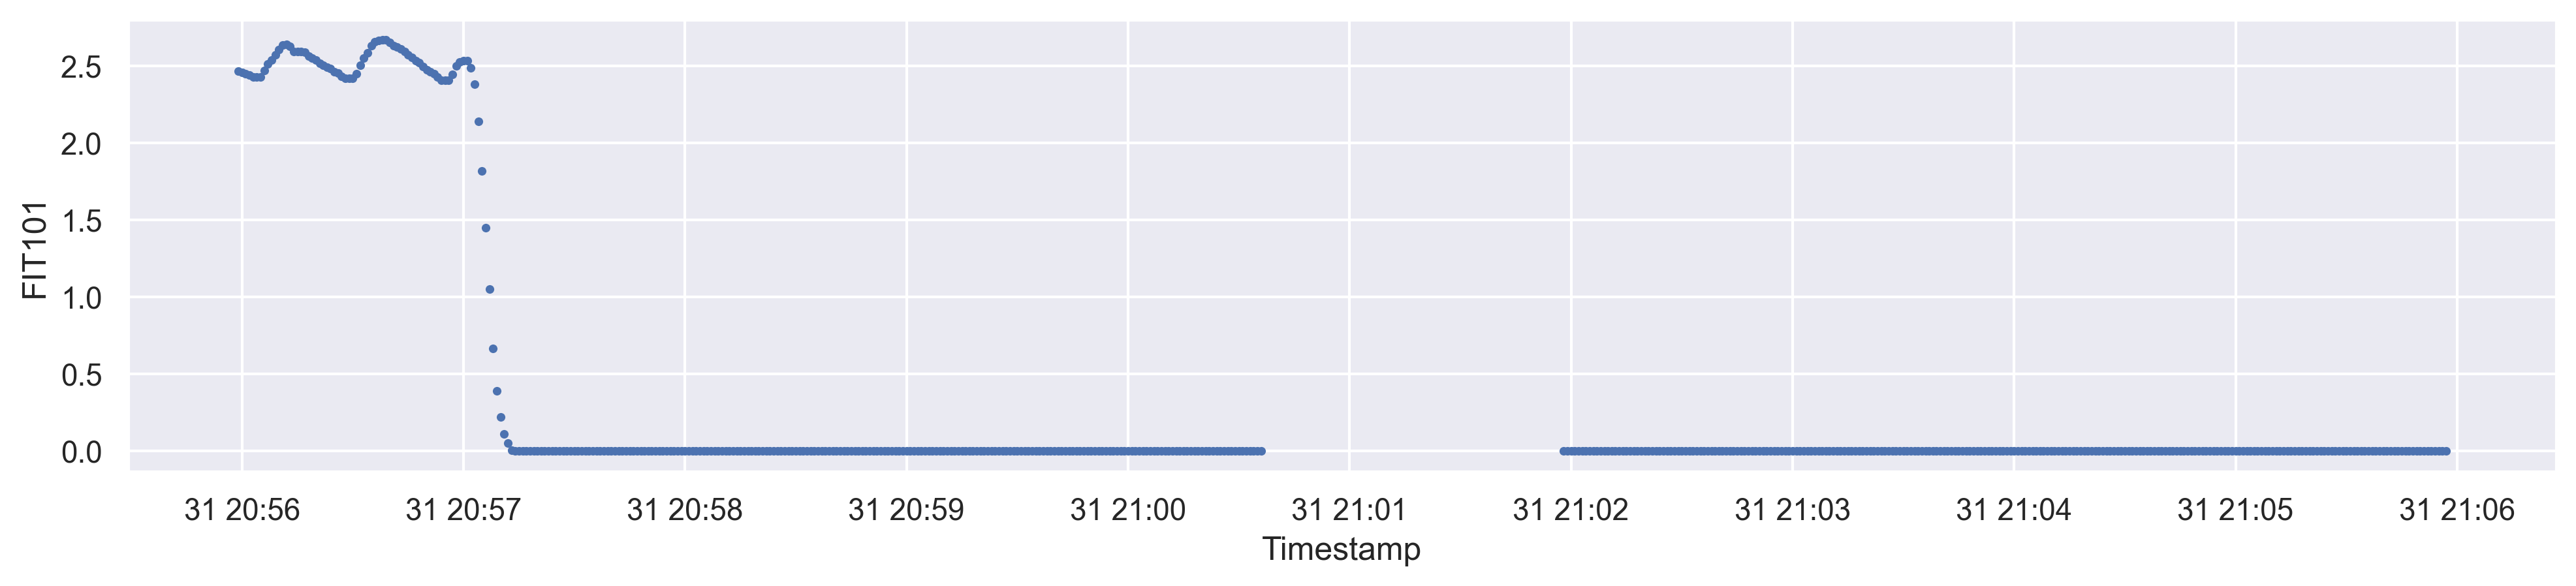

In [25]:
# plot the feature FIT101 at 015-12-31 21:01:58
fig, ax = plt.subplots(figsize=(16, 3), dpi=300)
# plot the feature FIT101 at 015-12-31 21:01:58
data = df[(df['Timestamp'] < '2015-12-31 21:05:58') & (df['Timestamp'] > '2015-12-31 20:55:58')]
sns.scatterplot(data=data, x='Timestamp', y='FIT101', ax=ax, s=10, alpha=1, marker='o', linewidth=0)

fig.savefig('figures/missed_data_fit101.pdf', bbox_inches='tight')

Start at 20h the dataset to remove the start process 

In [18]:
df = df[df['Timestamp'] > '2015-12-22 19:59:59']
df = df.reset_index(drop=True)

remove the label attack of an unreal attack start at 2015-12-22 6:30:00 and end at 6:42:00

In [23]:
df[df['Timestamp'].between('2015-12-29 06:29:59', '2015-12-29 06:42:01')][['Timestamp', 'Normal/Attack']]


,Timestamp,Normal/Attack
556199,2015-12-29 06:29:59,Normal
556200,2015-12-29 06:30:00,Attack
556201,2015-12-29 06:30:01,Attack
556202,2015-12-29 06:30:02,Attack
556203,2015-12-29 06:30:03,Attack
...,...,...
556917,2015-12-29 06:41:57,Attack
556918,2015-12-29 06:41:58,Attack
556919,2015-12-29 06:41:59,Attack
556920,2015-12-29 06:42:00,Attack


In [24]:
df.loc[(df['Timestamp'].between('2015-12-29 06:29:59', '2015-12-29 06:42:01')), 'Normal/Attack'] = 'Normal'


In [25]:
df[df['Timestamp'].between('2015-12-29 06:29:59', '2015-12-29 06:42:01')][['Timestamp', 'Normal/Attack']]


,Timestamp,Normal/Attack
556199,2015-12-29 06:29:59,Normal
556200,2015-12-29 06:30:00,Normal
556201,2015-12-29 06:30:01,Normal
556202,2015-12-29 06:30:02,Normal
556203,2015-12-29 06:30:03,Normal
...,...,...
556917,2015-12-29 06:41:57,Normal
556918,2015-12-29 06:41:58,Normal
556919,2015-12-29 06:41:59,Normal
556920,2015-12-29 06:42:00,Normal


## **Normalization of dataset**

In [26]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('Normal/Attack')
cols_numeric.remove('index')

mean normalization

In [27]:
data = df[cols_numeric]
mean_normalized_df = (data-data.mean())/data.std()

min-max normalization

In [28]:
data = df[cols_numeric]
min_max_normalized_df = (data-data.min())/(data.max()-data.min())

## Add attack identification number

In [29]:
attacks_list_df = pd.read_csv('attacks_df.csv')

In [30]:
attacks_list_df['start_time'] = pd.to_datetime(attacks_list_df['start_time'])
attacks_list_df['end_time'] = pd.to_datetime(attacks_list_df['end_time'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

delta_time = pd.Timedelta(minutes=0)

df['attack'] = 0
for i in range(len(attacks_list_df)):
    attack_num = attacks_list_df.iloc[i]
    s = df['Timestamp'].between(attack_num['start_time'] - delta_time, attack_num['end_time'] + delta_time)
    df['attack'].loc[s] = attack_num['num_attack']

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_7339/3300264022.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['attack'].loc[s] = attack_num['num_attack']


## remove feature with a variance of 0

In [ ]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('Normal/Attack')
cols_numeric.remove('index')
for col in cols_numeric:
    var = np.var(df[col])
    if var == 0:
        print(col)
        cols_numeric.remove(col)

In [ ]:
df = df.drop(columns=['P202','P401','P404','P502','P601','P603'])

In [31]:
df.to_pickle('dataset/train_dataset.pkl')